# Air cargo forecasting v2

Data based on monthly statistics from [transstats](https://www.transtats.bts.gov/freight.asp) crawled by [scrapy](https://scrapy.org/). The unit of measurement is ton$\cdot$mile.

### The goal:
Construct the multivatiate model (5 features: regions) to evaluate quantities twelve months into the future, based on data from previous twelve months.

### Overview:
1. Data preparation
2. Time series analysis
3. SARIMA model
4. LSTM model
5. Prediction into the unknown future

## 1. Data preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from pmdarima import auto_arima

import os
import glob
import re

In [3]:
df = pd.read_json('Data/AirCargoData.json')
df = df.set_index(pd.to_datetime({'year': df['Year'], 'month': pd.to_datetime(df['Month'], format='%B').dt.month, 'day': 1}))
df = df.drop(['Year', 'Month', 'Total'], axis=1)
df.columns = [str.replace(x, '*', '') for x in df.columns]
df.index.freq = 'MS'
df

,Domestic,Atlantic,Latin America,Pacific,International
2002-10-01,1458.666,486.393,152.429,827.855,2667.598
2002-11-01,1296.241,480.208,128.744,780.295,2463.807
2002-12-01,1262.516,424.351,161.397,643.024,2071.804
2003-01-01,1177.785,394.155,135.919,591.492,1948.974
2003-02-01,1079.561,423.668,159.528,553.606,1909.486
...,...,...,...,...,...
2021-08-01,1677.204,653.497,137.104,886.911,4215.407
2021-09-01,1649.291,698.960,136.378,883.809,4114.244
2021-10-01,1734.279,751.973,148.173,955.919,4432.605
2021-11-01,1727.082,674.997,145.472,943.245,4278.257


In [4]:
def plot_series(df,
                predictions=None,
                size=(25,16),
                pred_label='',
                title=''
               ):
    fig = plt.figure(figsize=size)
    plt.title(title, size=2*size[0])
    cols = df.columns
    colors = {cols[0]: 'red',
          cols[1]: 'orange',
          cols[2]: 'violet',
          cols[3]: 'green',
          cols[4]: 'blue'}
    for col in cols:
        plt.plot(df[col], linestyle='solid', c=colors[col], label=col)
        if type(predictions) == pd.core.frame.DataFrame:
            plt.plot(predictions[col], linestyle='dashed', c=colors[col], label=f'{pred_label} for {col}')
    plt.legend(prop={'size': size[1]})
    plt.show()

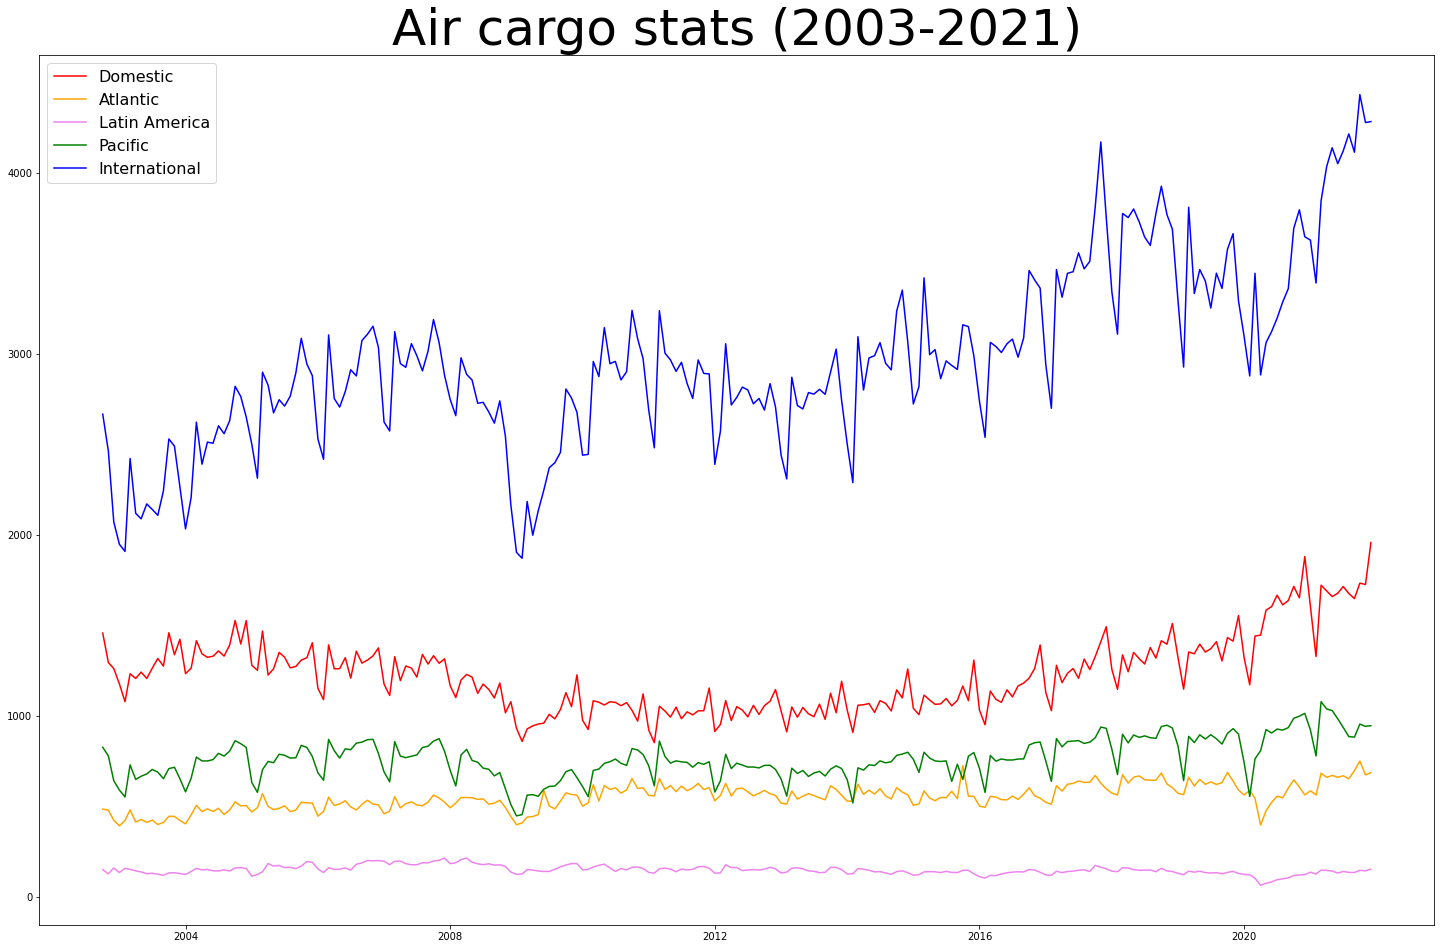

In [5]:
plot_series(df=df, title='Air cargo stats (2003-2021)')

### 1.1 Train/test split

In [6]:
def train_test_split(df, m):
    if m > 0.5*len(df):
        m = int(0.5*len(df))
    train = df[:-m]
    test = df[-m:]
    return train, test

df_train, df_test = train_test_split(df=df, m=12)

### 1.2 Error evaluation

In [7]:
def evaluation_params(test, predictions):
    err = mse(test, predictions, squared=False)
    ratio = err / test.mean()
    return err, ratio

def evaluation_df(test, pred):
    evaluation = {}
    for c in test.columns:
        err, ratio = evaluation_params(test[c], pred[c])
        evaluation[c] = {'error': err, 'ratio': ratio}
    evaluation = pd.DataFrame.from_dict(evaluation, orient='index')
    return evaluation

def evaluation_ratio(evaluation):
    ratio = {}
    ratio['mean'] = evaluation['ratio'].mean()
    ratio['max'] = evaluation['ratio'].max()
    return ratio

## 2. Time series analysis

### 2.1 Stationarity

In [8]:
for col in df.columns:
    print(f'Augmented Dickey-Fuller test for {col} series.')
    test = adfuller(df[col])
    result = 'stationary' if test[1] <= 0.05 else 'non-stationary'
    print(f'Since p-value={test[1]:.4f}, the {col} series is {result}.\n')

Augmented Dickey-Fuller test for Domestic series.
Since p-value=0.9037, the Domestic series is non-stationary.

Augmented Dickey-Fuller test for Atlantic series.
Since p-value=0.1912, the Atlantic series is non-stationary.

Augmented Dickey-Fuller test for Latin America series.
Since p-value=0.2707, the Latin America series is non-stationary.

Augmented Dickey-Fuller test for Pacific series.
Since p-value=0.0755, the Pacific series is non-stationary.

Augmented Dickey-Fuller test for International series.
Since p-value=0.5412, the International series is non-stationary.



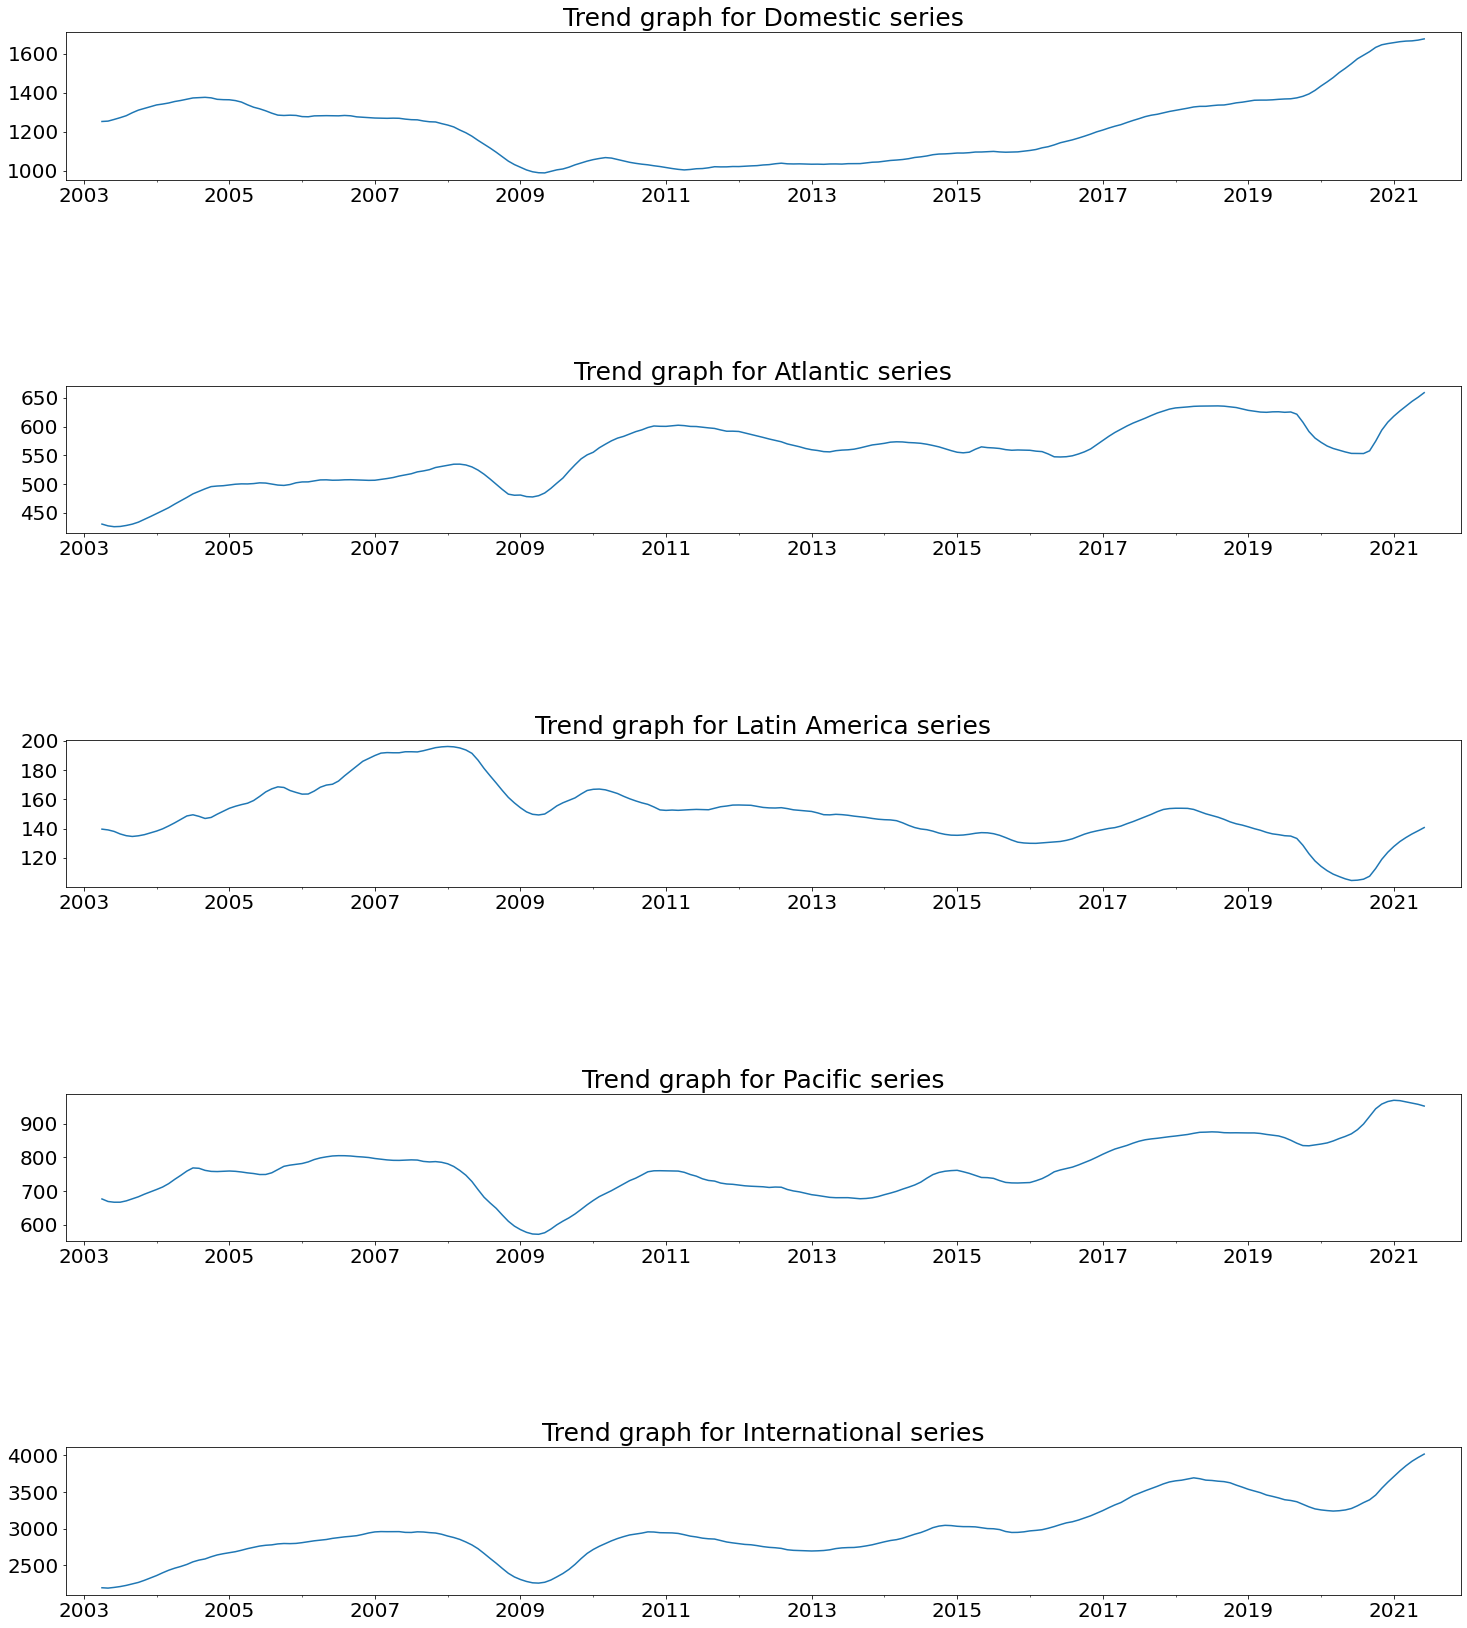

In [9]:
fig = plt.figure(figsize=(25,32))

for idx, col in enumerate(df.columns):
    ax = fig.add_subplot(10, 1, 2*idx+1)
    seasonal_decompose(df[col]).trend.plot(ax=ax)
    ax.set_title(f'Trend graph for {col} series', fontsize=25)
    for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
plt.show()

There is a downfall slope (ca. 2009) for all series which can be explained by the economical crisis. For all the series, except for Domestic, there is a downfall slope caused by the COVID-19 pandemic (2020). It suggests adding an exogenous factor to the model.

### 2.2 Seasonality

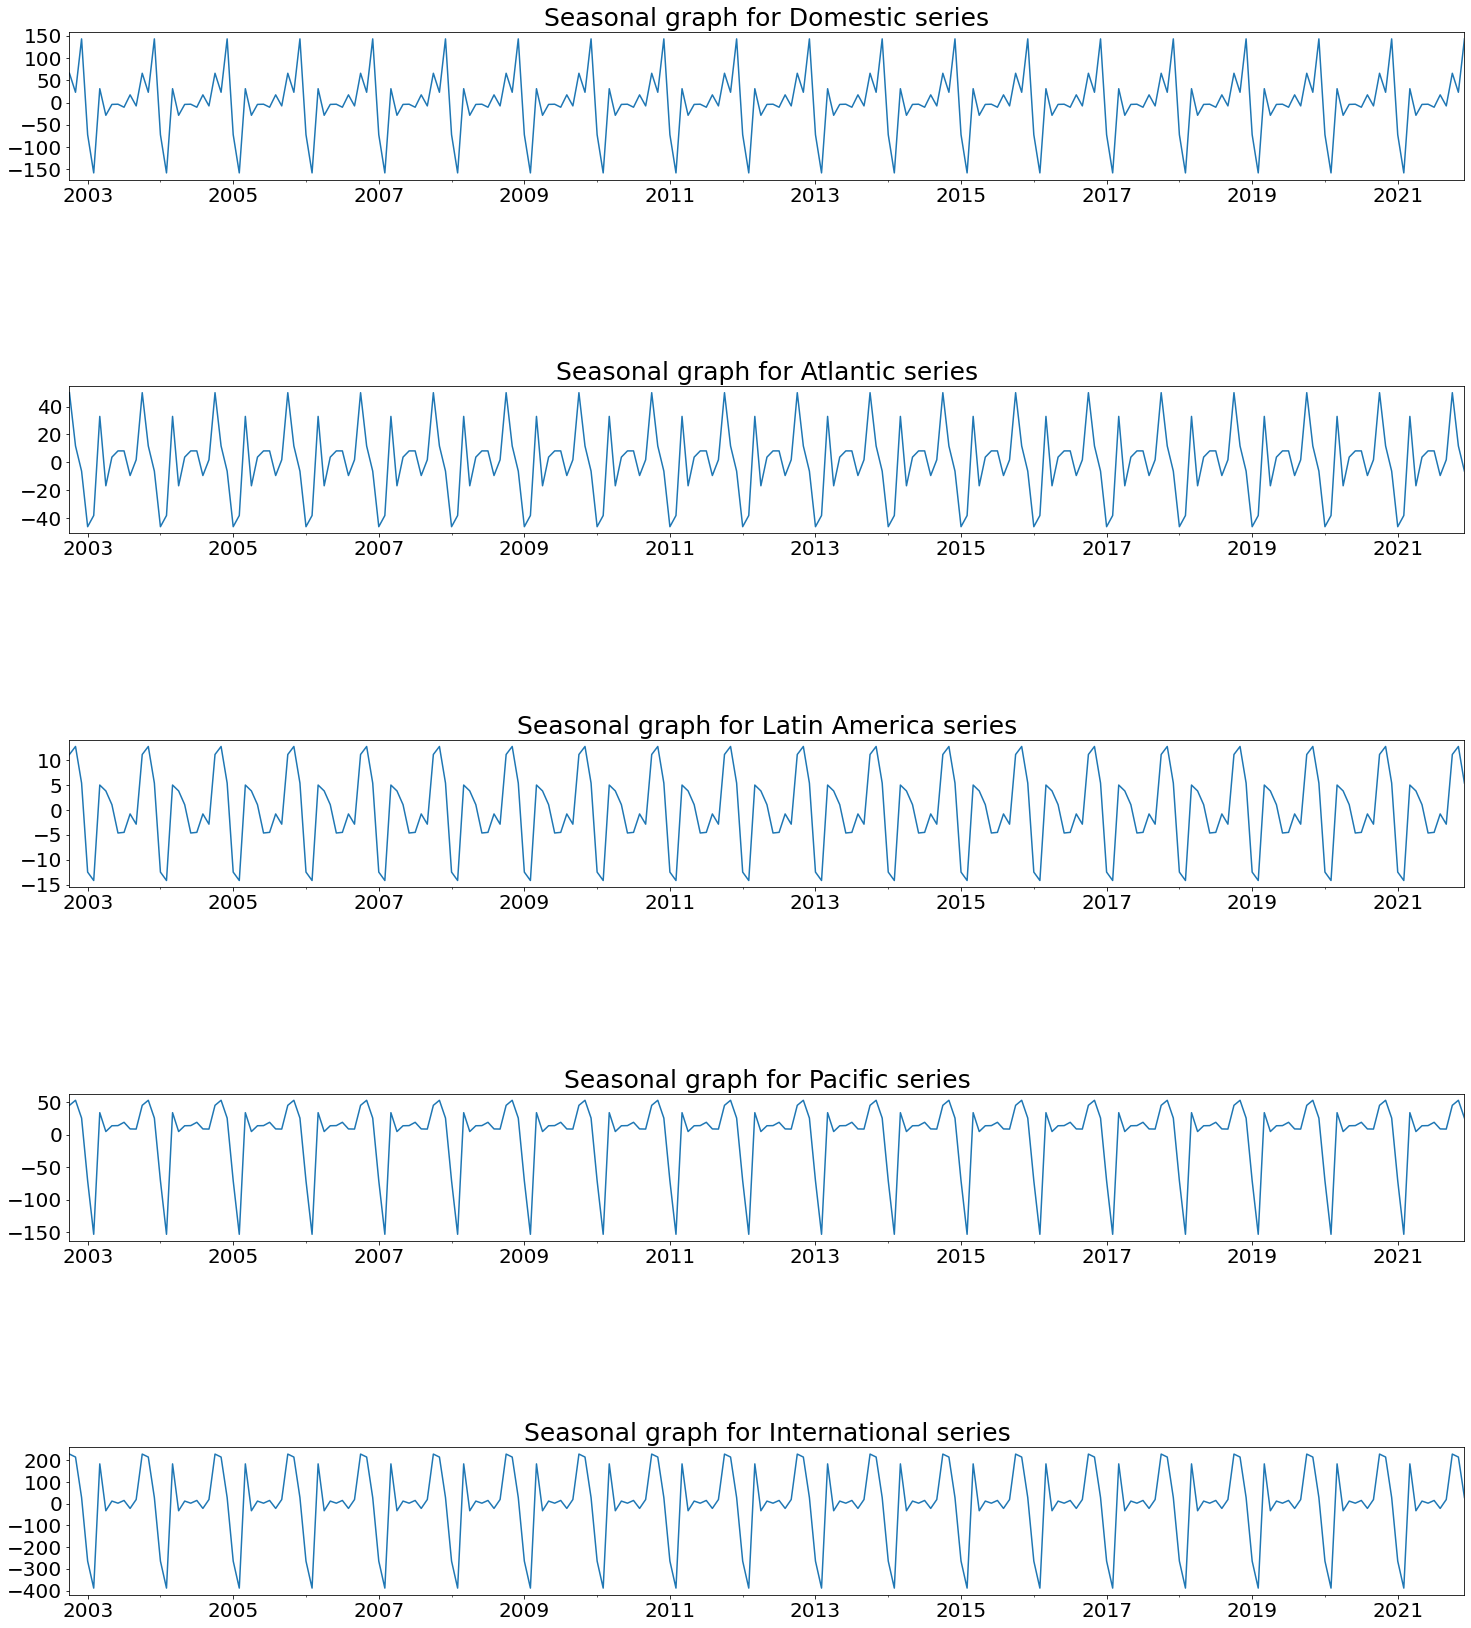

In [10]:
fig = plt.figure(figsize=(25,32))

for idx, col in enumerate(df.columns):
    ax = fig.add_subplot(10, 1, 2*idx+1)
    seasonal_decompose(df[col]).seasonal.plot(ax=ax)
    ax.set_title(f'Seasonal graph for {col} series', fontsize=25)
    for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
plt.show()

The data has obviusly seasonality with $m=12$.

### 2.3 Choosing SARIMA parameters (ACF, PACF, pmdarima API)

In [11]:
def plot_lags(df, method='acf', title_add ='', lags=40, figsize=(25,16)):
    fig = plt.figure(figsize=figsize)

    for idx, col in enumerate(df.columns):
        ax = fig.add_subplot(2, 3, idx+1)
        plot_acf(df[col], lags=lags, ax=ax)
        ax.set_title(f'{method.upper()} graph for {col} series {title_add}', fontsize=figsize[0])
    plt.show()

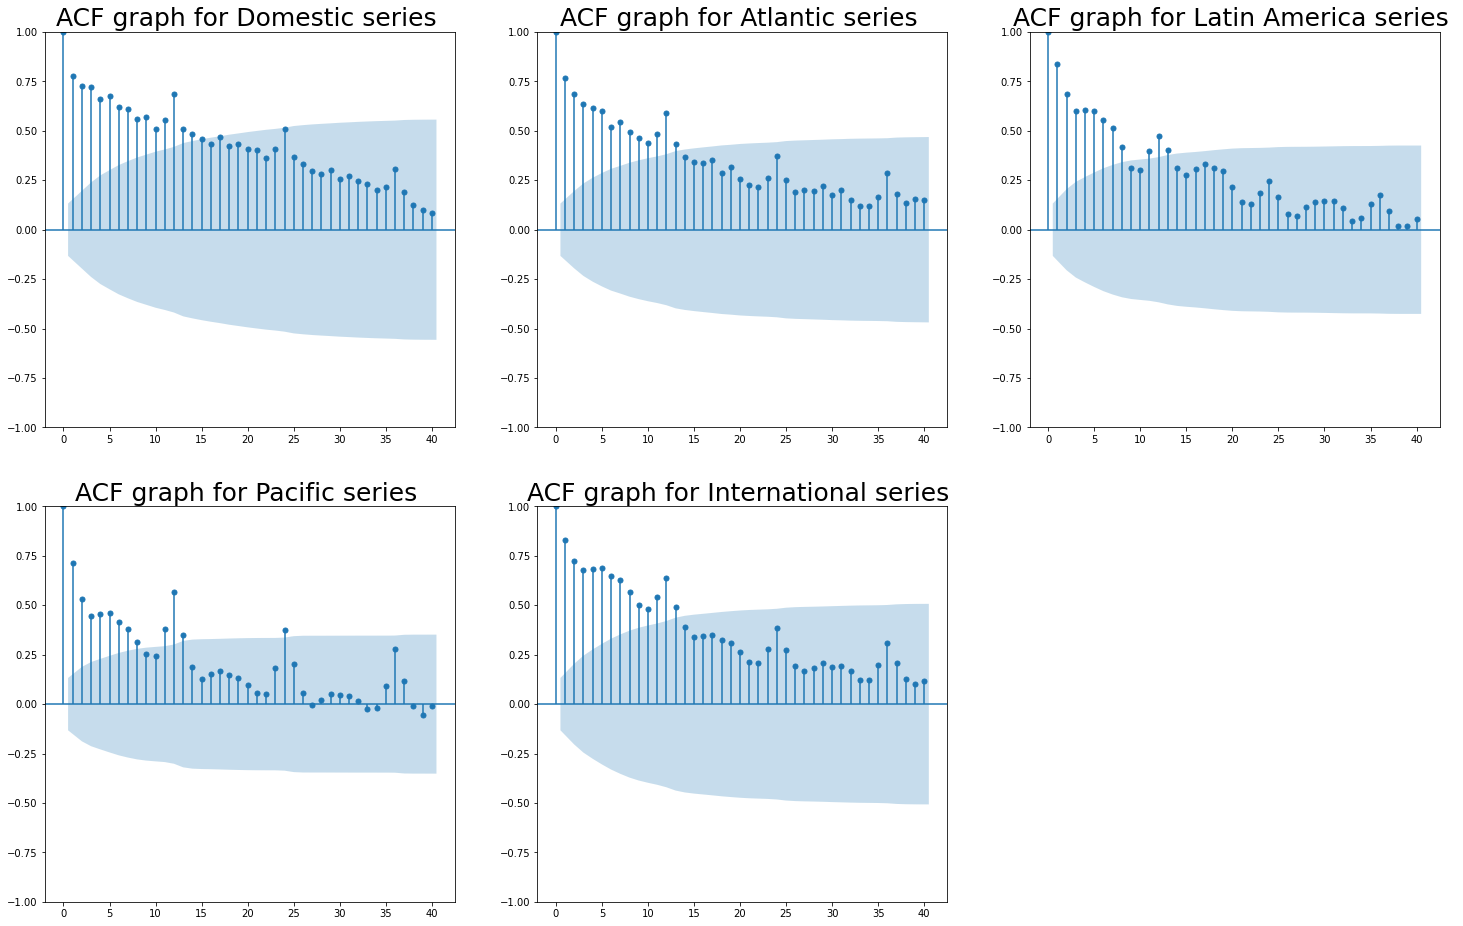

In [12]:
plot_lags(df_train, method='acf')

For all cases, autocorrelation decreases slowly which suggests adding an $I$ factor to the model.

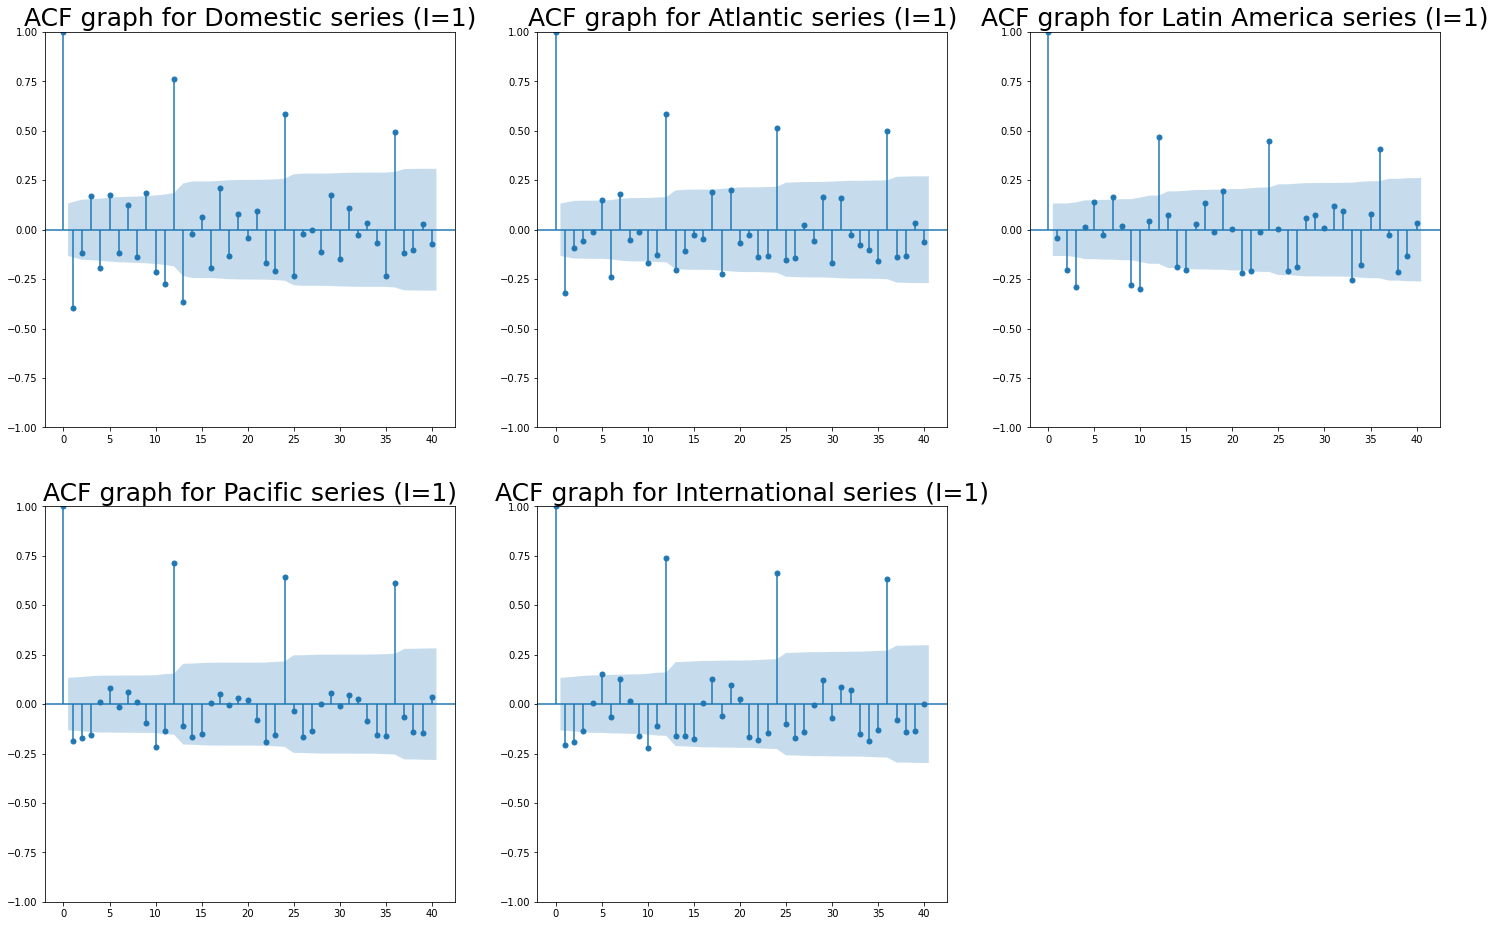

In [13]:
plot_lags(df_train.diff(1).dropna(), method='acf', title_add='(I=1)')

In [14]:
for col in df.columns:
    print(f'Augmented Dickey-Fuller test for {col} series\' 1st difference.')
    test = adfuller(df_train[col].diff(1).dropna())
    result = 'stationary' if test[1] <= 0.05 else 'non-stationary'
    print(f'Since p-value={test[1]:.4f}, the {col} series\' 1st difference is {result}.\n')

Augmented Dickey-Fuller test for Domestic series' 1st difference.
Since p-value=0.0902, the Domestic series' 1st difference is non-stationary.

Augmented Dickey-Fuller test for Atlantic series' 1st difference.
Since p-value=0.0023, the Atlantic series' 1st difference is stationary.

Augmented Dickey-Fuller test for Latin America series' 1st difference.
Since p-value=0.0000, the Latin America series' 1st difference is stationary.

Augmented Dickey-Fuller test for Pacific series' 1st difference.
Since p-value=0.0130, the Pacific series' 1st difference is stationary.

Augmented Dickey-Fuller test for International series' 1st difference.
Since p-value=0.0326, the International series' 1st difference is stationary.



Since the 1st differences are stationary and all their 1-lag autocorrelations drop below $0$, there is strong evidence to apply $I=1$. The values on 1st lag are not below $-0.5$ which suggests there is no overdifferencing. However, it is worth considering the $MA$ factor up to the 3rd level.

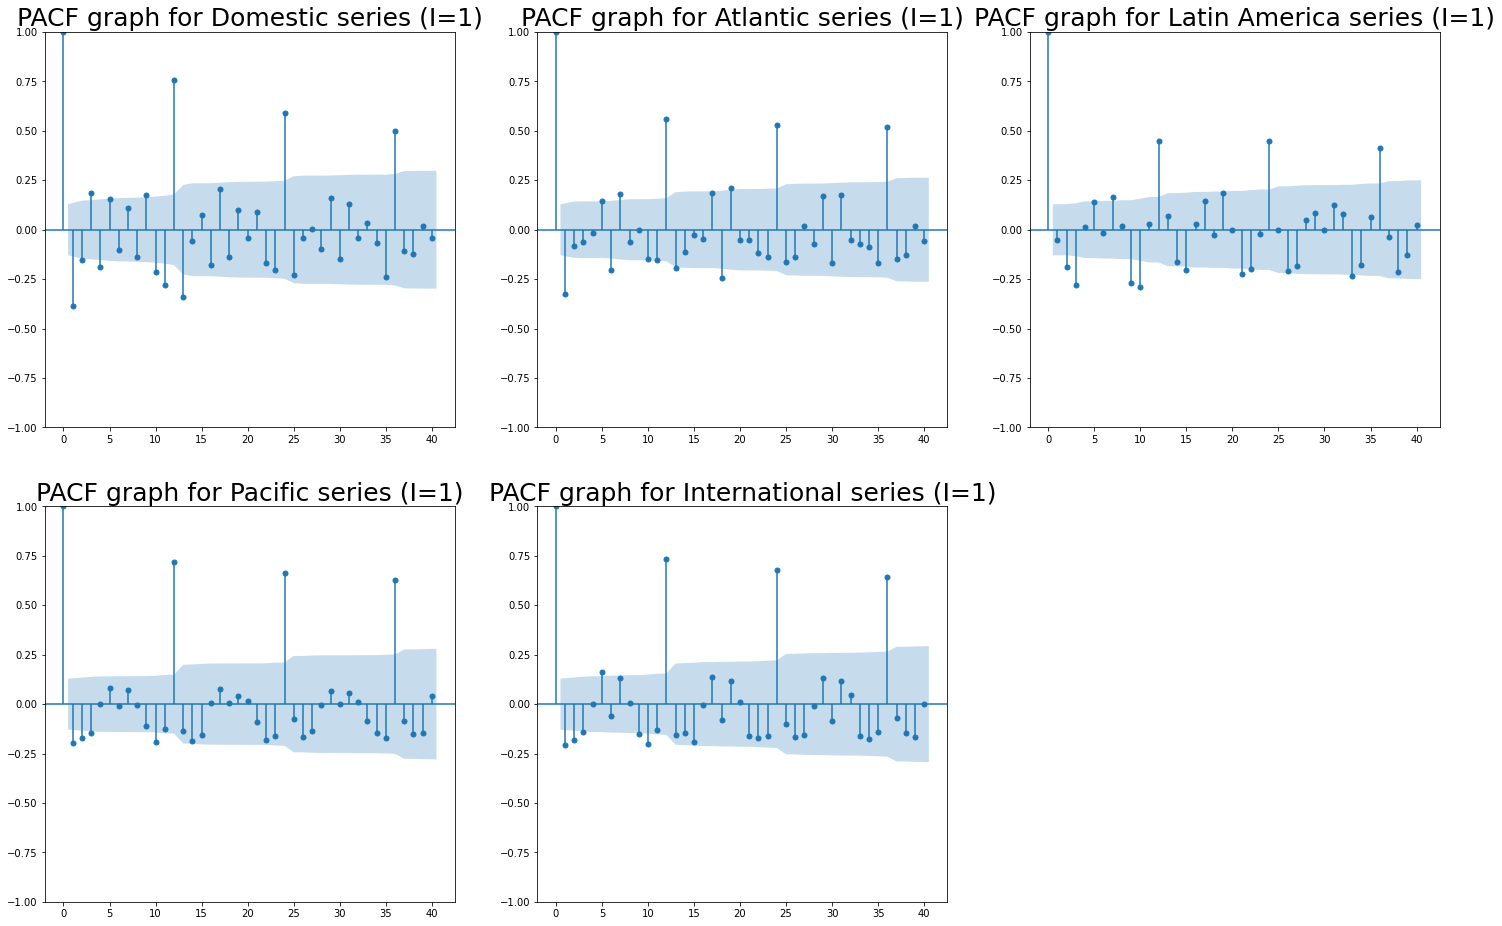

In [15]:
plot_lags(df.diff(1).dropna(), method='pacf', title_add='(I=1)')

For differenced data, PACF graphs have sharp cutoffs on 1-lags which suggests $AR \in \{0,1\}$.

Since the data has seasonality, and for the 1st difference on 12, 24, and 36-lag the ACF obtains strongly positive values, I use $SI=1$ (for all regions).

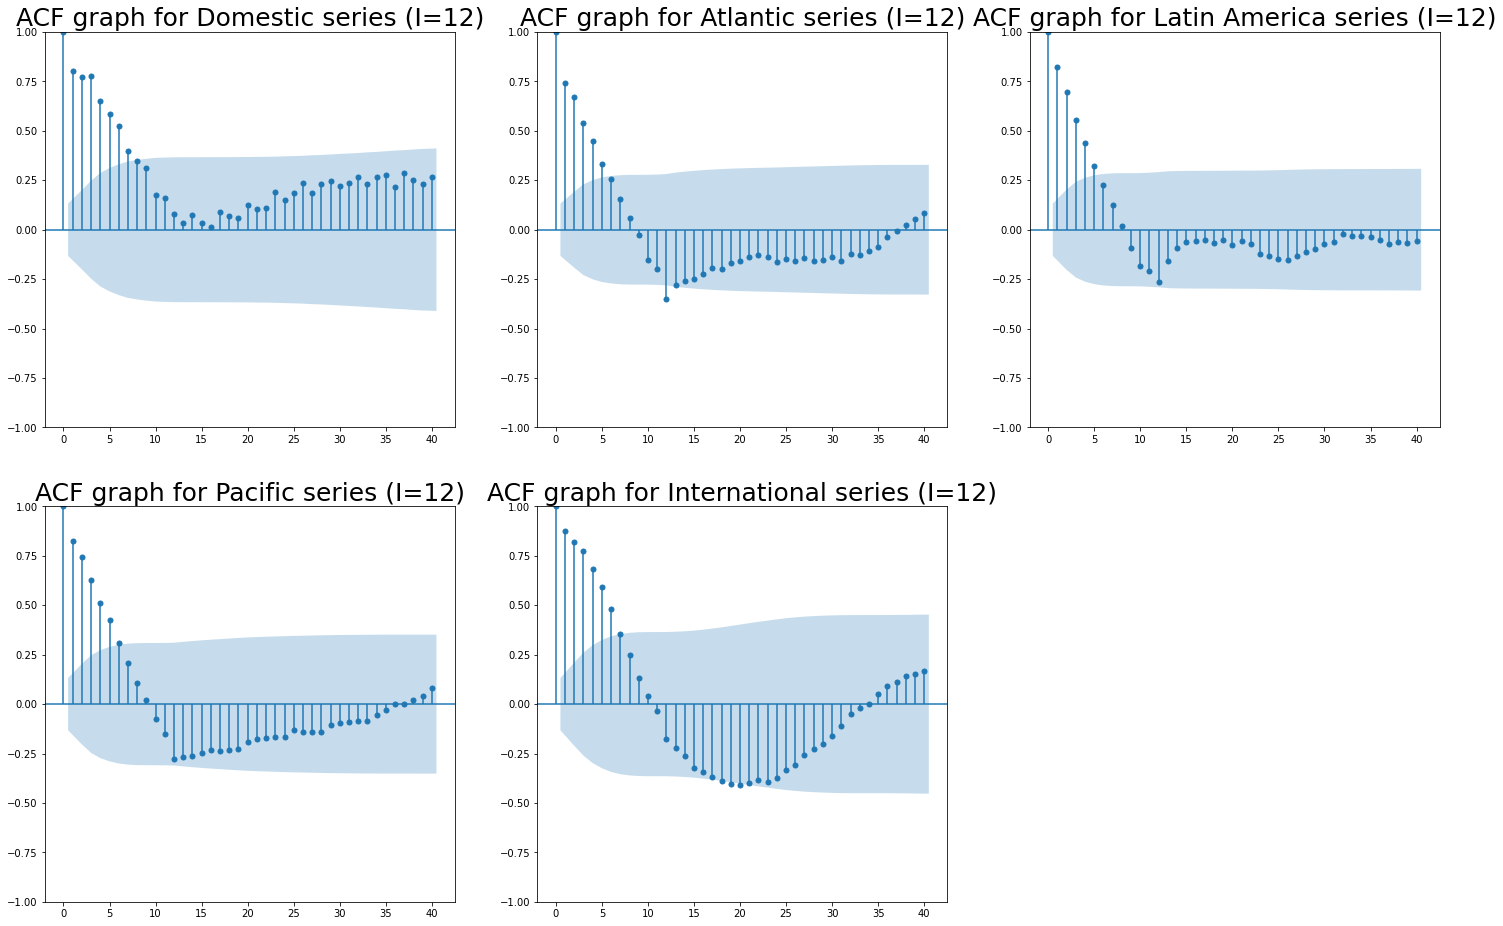

In [16]:
plot_lags(df.diff(12).dropna(), method='acf', title_add='(I=12)')

According to the ACF graph for 12 times differenced data, where 12-lag is positive for the Domestic series and negative for others, we should consider adding a SAR parameter to the Domestic series model and an SMA parameter to the others.

To find the best parameters for all the models, I will use auto_arima from pmdarima API. To achieve more possibilities, I will seek through more various parameters with the stepwise fit (to faster computation and lower risk of obtaining overfited model). The idea: minimize the AIC. Due to previous analysis, considering SARIMA(p,d,q)x(P,D,Q,m), I will seek the parameters in the following ranges:
- $p \in \{0,1,2,3\}$ for all series
- $d = 1$ for all series
- $q \in \{0,1,2,3\}$ for all series
- $P \in \{0,1\}$ for Domestic series, $P=0$ for others
- $D = 1$ for all series
- $Q = 0$ for Domestic series, $Q \in \{0,1\}$ for others
- $m=12$ for all series

In [17]:
def stepwise_fit(df,
                 start_p=0, max_p=3,
                 d=1,
                 start_q=0, max_q=3,
                 start_P=0, max_P=1,
                 D=1,
                 start_Q=0, max_Q=1,
                 seasonal=True, trace=True, m=12):
    fit = {}
    for col in df.columns:
        print(f'Seeking the best fit for {col} series')
        fit[col] = auto_arima(df[col],
                   start_p=start_p, max_p=max_p,
                   d=d,
                   start_q=start_q, max_q=max_q,
                   start_P=start_P, max_P=max_P,
                   D=D,
                   start_Q=start_Q, max_Q=max_Q,
                   seasonal=seasonal, trace=trace, m=m)
        print()
    return fit

In [18]:
stepwise_fit = stepwise_fit(df_train)

Seeking the best fit for Domestic series
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2309.468, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2263.695, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2237.421, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2260.118, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2225.512, Time=0.48 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2255.351, Time=0.13 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2224.602, Time=0.64 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2235.291, Time=0.35 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2251.742, Time=0.19 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2257.702, Time=0.04 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=2233.258, Time=0.50 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=2206.718, Time=0.66 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=2210.08

## 3. SARIMA model

In [19]:
def sarima_model(df, stepwise_fit):
    sarima = {}
    for c in df.columns:
        params = stepwise_fit[c].get_params()
        model = SARIMAX(endog=df_train[c], order=params['order'], seasonal_order=params['seasonal_order'], method=params['method'])
        sarima[c] = model.fit(disp=False)
    return sarima

def sarima_predict(model, start, end, typ='levels'):
    predictions = {}
    for c in df.columns:
        predictions[c] = model[c].predict(start, end, typ=typ).rename(f'{c} SARIMA predictions')
    df_sarima = pd.DataFrame(predictions)
    return df_sarima

In [20]:
sarima = sarima_model(df=df_train, stepwise_fit=stepwise_fit)

In [21]:
df_sarima = sarima_predict(model=sarima, start=len(df_train), end=len(df_train)+len(df_test)-1, typ='levels')
df_sarima

,Domestic,Atlantic,Latin America,Pacific,International
2021-01-01,1611.675390,540.371788,107.263115,884.451704,3303.578834
2021-02-01,1475.916895,546.370735,103.217290,727.881330,3123.567053
2021-03-01,1738.863276,614.210240,113.445042,935.348265,3772.178502
2021-04-01,1689.860984,556.887909,104.686342,919.580217,3484.969120
2021-05-01,1785.038246,590.837123,106.206690,973.007907,3572.172540
2021-06-01,1801.560392,600.346280,103.353225,955.229095,3564.201044
2021-07-01,1816.080762,609.547455,106.369113,966.414477,3572.655311
2021-08-01,1819.141561,599.432416,108.139179,948.392172,3577.055622
2021-09-01,1809.386380,613.933077,105.549793,947.080698,3615.515941
2021-10-01,1887.159969,668.754516,120.737105,990.563192,3861.644481


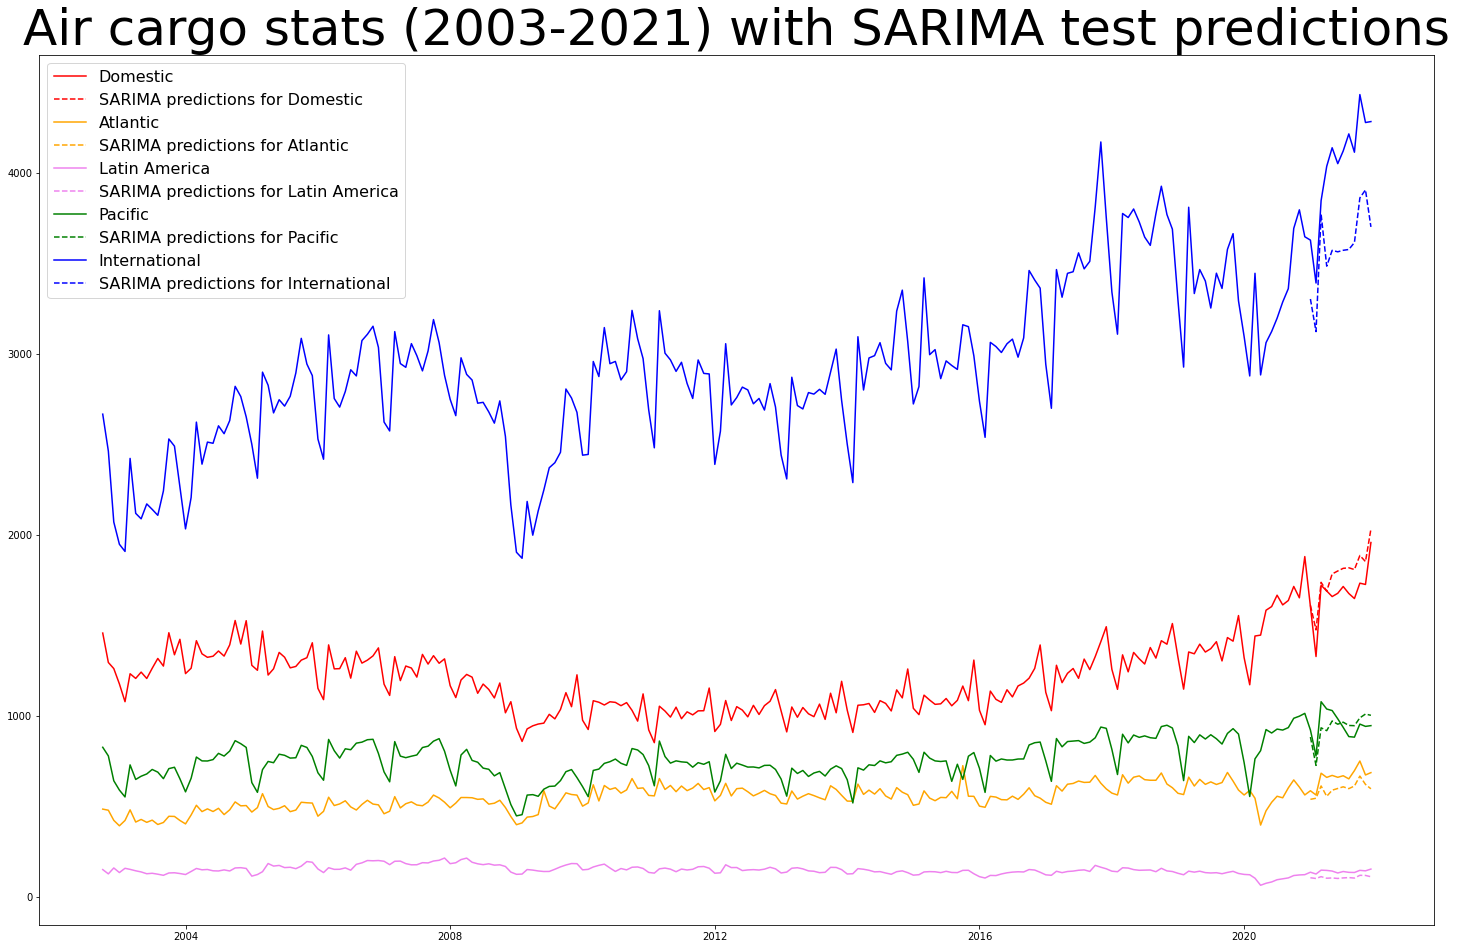

In [22]:
plot_series(df=df, predictions=df_sarima, pred_label='SARIMA predictions', title='Air cargo stats (2003-2021) with SARIMA test predictions')

In [23]:
sarima_evaluation = evaluation_df(df_test, df_sarima)
sarima_evaluation

,error,ratio
Domestic,113.013646,0.067302
Atlantic,70.980073,0.106862
Latin America,33.278412,0.234223
Pacific,71.380787,0.075188
International,483.532636,0.119540


In [24]:
sarima_ratio = evaluation_ratio(sarima_evaluation)
print(f"Mean ratio for SARIMA: {sarima_ratio['mean']}")
print(f"Max ratio for SARIMA: {sarima_ratio['max']}")

Mean ratio for SARIMA: 0.12062295934525939
Max ratio for SARIMA: 0.23422292151863205


## 4. LSTM model

In the following algorithm, I will extract two models having
- the lowest mean ratio (error / test_mean)
- the lowest max ratio

For a given number of epochs, the algorithm will search through the different approaches having various:
- LSTM layer sizes
- second LSMT layer sizes (optional)
- Dropout layers (to add noise to the model)

I have chosen $n_{epochs}=40$ in order not to overfit the model.

In [25]:
look_back = 12 # predicting the values basing on last {look_back} months
n_features = df_train.shape[1]

scaler = MinMaxScaler()
scaler.fit(df_train)
train_s = scaler.transform(df_train)
test_s = scaler.transform(df_test)

generator = TimeseriesGenerator(train_s, train_s, length=look_back, batch_size=1)

In [26]:
def lstm(input_shape=(12,5),
         n1=200, act1='relu',
         dropout=0.0,
         n2=0, act2='relu'):
    model = Sequential()
    r = bool(n2)
    model.add(LSTM(n1, activation=act1, input_shape=input_shape, return_sequences=r))
    if r:
        model.add(LSTM(n2, activation=act2, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(input_shape[1]))
    return model

def predict_lstm(model, train_s, index, scaler, columns,
                 look_back=12, n_features=5, test_size=12):
    test_p = []
    first_eval_batch = train_s[-look_back:]
    current_batch = first_eval_batch.reshape((1, look_back, n_features))
    for i in range(test_size):
        current_pred = model.predict(current_batch)[0]
        test_p.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)
    test_p = scaler.inverse_transform(test_p)
    df_lstm = pd.DataFrame(test_p, columns=columns, index=index)
    return df_lstm, model

def choose_lstm(df, train, test,
                look_back=12, n_epochs=100,
                optimizer='adam', loss='mse',
                n1=[200], act1='relu',
                n2=[0], act2='relu',
                min_dropout=0.0, max_dropout=0.6, n_dropouts=7):
    models = {'mean': None, 'max': None}
    histories = {'mean': None, 'max': None}
    predictions = {'mean': None, 'max': None}
    scores = {'mean': float('inf'), 'max': float('inf')}
    dropouts = np.linspace(min_dropout, max_dropout, n_dropouts)
    n_features = train.shape[1]
    input_shape = (look_back, n_features)
    
    scaler = MinMaxScaler()
    scaler.fit(train)
    train_s = scaler.transform(train)
    
    generator = TimeseriesGenerator(train_s, train_s,
                                    length=look_back, batch_size=1)
    for n in n1:
        for m in n2:
            for d in dropouts:
                model = lstm(input_shape=input_shape,
                            n1=n, act1=act1,
                            dropout=d,
                            n2=m, act2=act2)
                model.compile(optimizer=optimizer, loss=loss)
                h = model.fit(generator, epochs=n_epochs, verbose=0)
                pred, model = predict_lstm(model=model, train_s=train_s, index=df.index[-len(test):], scaler=scaler, columns = df.columns,
                                   look_back=look_back, n_features=n_features, test_size=len(test))
                evaluation = evaluation_df(test, pred)
                rmean = evaluation['ratio'].mean()
                rmax = evaluation['ratio'].max()
                info = f'->LSTM({m})' if m > 0 else ''
                print(f"Model: LSTM({n}){info}->Dropout({d:.2f})->Dense({n_features}), {n_epochs=}")
                print(f"loss={h.history['loss'][-1]:.4f}, {rmean=:.4f}, {rmax=:.4f}\n")
                if rmean < scores['mean']:
                    models['mean'] = model
                    histories['mean'] = h
                    predictions['mean'] = pred
                    scores['mean'] = rmean
                if rmax < scores['max']:
                    models['max'] = model
                    histories['max'] = h
                    predictions['max'] = pred
                    scores['max'] = rmax
    return models, histories, predictions, scores

In [27]:
models, histories, predictions, scores = choose_lstm(df=df, train=df_train, test=df_test,
                                         look_back=12, n_epochs=40,
                                         n1=[150, 200, 250], act1='tanh',
                                         n2=[0, 120, 150], act2='tanh')

Model: LSTM(150)->Dropout(0.00)->Dense(5), n_epochs=40
loss=0.0051, rmean=0.1167, rmax=0.1705

Model: LSTM(150)->Dropout(0.10)->Dense(5), n_epochs=40
loss=0.0081, rmean=0.1737, rmax=0.2795

Model: LSTM(150)->Dropout(0.20)->Dense(5), n_epochs=40
loss=0.0097, rmean=0.1807, rmax=0.2692

Model: LSTM(150)->Dropout(0.30)->Dense(5), n_epochs=40
loss=0.0113, rmean=0.1557, rmax=0.2131

Model: LSTM(150)->Dropout(0.40)->Dense(5), n_epochs=40
loss=0.0115, rmean=0.1002, rmax=0.1794

Model: LSTM(150)->Dropout(0.50)->Dense(5), n_epochs=40
loss=0.0131, rmean=0.1109, rmax=0.1734

Model: LSTM(150)->Dropout(0.60)->Dense(5), n_epochs=40
loss=0.0130, rmean=0.1395, rmax=0.2045

Model: LSTM(150)->LSTM(120)->Dropout(0.00)->Dense(5), n_epochs=40
loss=0.0042, rmean=0.1750, rmax=0.2329

Model: LSTM(150)->LSTM(120)->Dropout(0.10)->Dense(5), n_epochs=40
loss=0.0058, rmean=0.3047, rmax=0.6449

Model: LSTM(150)->LSTM(120)->Dropout(0.20)->Dense(5), n_epochs=40
loss=0.0069, rmean=0.1248, rmax=0.1714

Model: LSTM(150)-

### 4.1 The best "mean" model

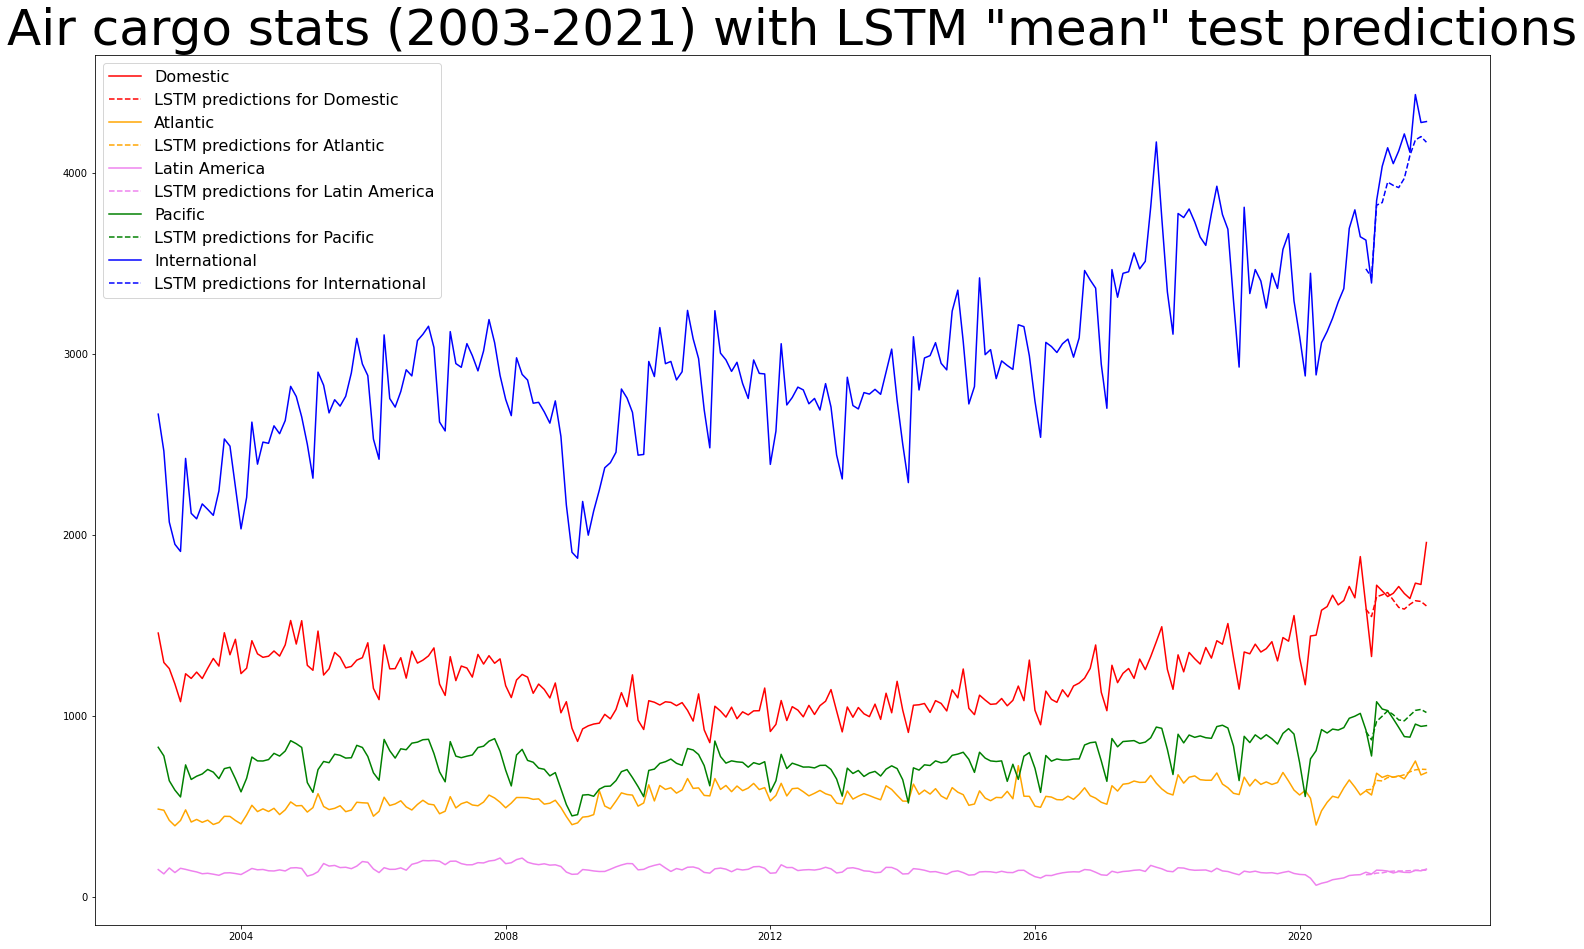

In [28]:
plot_series(df=df, predictions=predictions['mean'], pred_label='LSTM predictions', title='Air cargo stats (2003-2021) with LSTM "mean" test predictions')

In [29]:
lstm_mean_evaluation = evaluation_df(df_test, predictions['mean'])
lstm_mean_evaluation

,error,ratio
Domestic,134.851730,0.080307
Atlantic,24.815530,0.037360
Latin America,9.093003,0.063999
Pacific,73.812822,0.077750
International,158.324429,0.039141


In [30]:
lstm_mean_scores = evaluation_ratio(lstm_mean_evaluation)
print(f"Mean ratio for LSTM: {lstm_mean_scores['mean']}")
print(f"Max ratio for LSTM: {lstm_mean_scores['max']}")

Mean ratio for LSTM: 0.05971148776283928
Max ratio for LSTM: 0.08030695726070598


### 4.2 The safest "max" model

In [41]:
models['max'].summary()

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_97 (LSTM)              (None, 12, 250)           256000    
                                                                 
 lstm_98 (LSTM)              (None, 150)               240600    
                                                                 
 dropout_59 (Dropout)        (None, 150)               0         
                                                                 
 dense_59 (Dense)            (None, 5)                 755       
                                                                 
Total params: 497,355
Trainable params: 497,355
Non-trainable params: 0
_________________________________________________________________


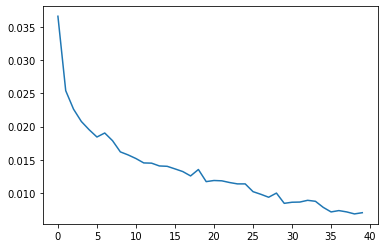

In [42]:
loss_max = histories['max'].history['loss']
plt.plot(range(len(loss_max)), loss_max)

In [37]:
models['mean'].summary()

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_97 (LSTM)              (None, 12, 250)           256000    
                                                                 
 lstm_98 (LSTM)              (None, 150)               240600    
                                                                 
 dropout_59 (Dropout)        (None, 150)               0         
                                                                 
 dense_59 (Dense)            (None, 5)                 755       
                                                                 
Total params: 497,355
Trainable params: 497,355
Non-trainable params: 0
_________________________________________________________________


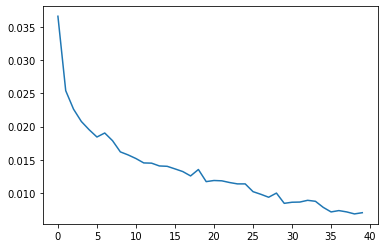

In [38]:
loss_mean = histories['mean'].history['loss']
plt.plot(range(len(loss_mean)), loss_mean)

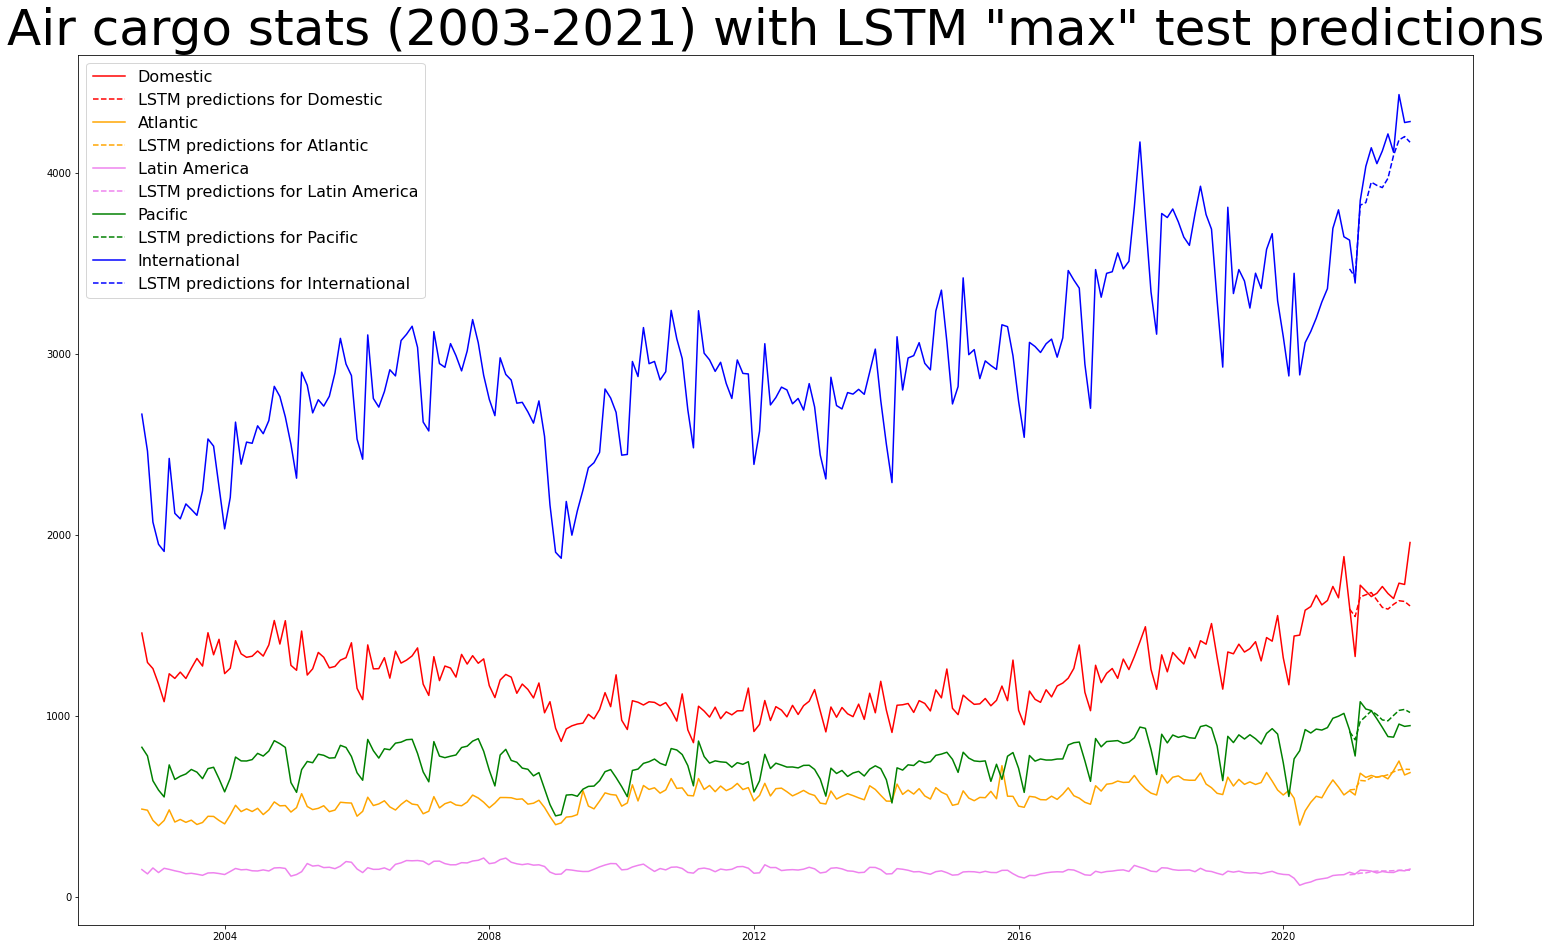

In [31]:
plot_series(df=df, predictions=predictions['max'], pred_label='LSTM predictions', title='Air cargo stats (2003-2021) with LSTM "max" test predictions')

In [32]:
lstm_max_evaluation = evaluation_df(df_test, predictions['max'])
lstm_max_evaluation

,error,ratio
Domestic,134.851730,0.080307
Atlantic,24.815530,0.037360
Latin America,9.093003,0.063999
Pacific,73.812822,0.077750
International,158.324429,0.039141


In [33]:
lstm_max_scores = evaluation_ratio(lstm_max_evaluation)
print(f"Mean ratio for LSTM: {lstm_max_scores['mean']}")
print(f"Max ratio for LSTM: {lstm_max_scores['max']}")

Mean ratio for LSTM: 0.05971148776283928
Max ratio for LSTM: 0.08030695726070598


## 5. Prediction into the unknown future

In [34]:
pred_start = df.index[-1] + pd.DateOffset(months=1)
pred_range = pd.date_range(pred_start, periods=12, freq='MS')
pred_range

DatetimeIndex(['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', freq='MS')

### 5.1 SARIMA model

In [35]:
df_sarima_future = sarima_predict(model=sarima, start=len(df), end=len(df)+11, typ='levels')
df_sarima_future = pd.concat([df_sarima_future, df.tail(1)]).sort_index()
df_sarima_future

,Domestic,Atlantic,Latin America,Pacific,International
2021-12-01,1958.740000,687.809000,155.231000,947.417000,4283.520000
2022-01-01,1785.776511,564.365485,97.669241,881.656314,3382.218424
2022-02-01,1661.306855,570.666783,95.155616,725.006891,3202.206644
2022-03-01,1895.717903,635.703003,108.158322,934.329183,3850.818093
2022-04-01,1852.028525,576.943140,99.399622,919.778126,3563.608711
2022-05-01,1933.073615,609.271465,100.919970,974.459812,3650.812130
2022-06-01,1939.884011,617.467780,98.066505,957.807108,3642.840635
2022-07-01,1951.177023,625.469232,101.082394,970.042251,3651.294902
2022-08-01,1965.455962,614.308143,102.852459,952.988292,3655.695213
2022-09-01,1944.657481,627.880300,100.263073,952.572691,3694.155531


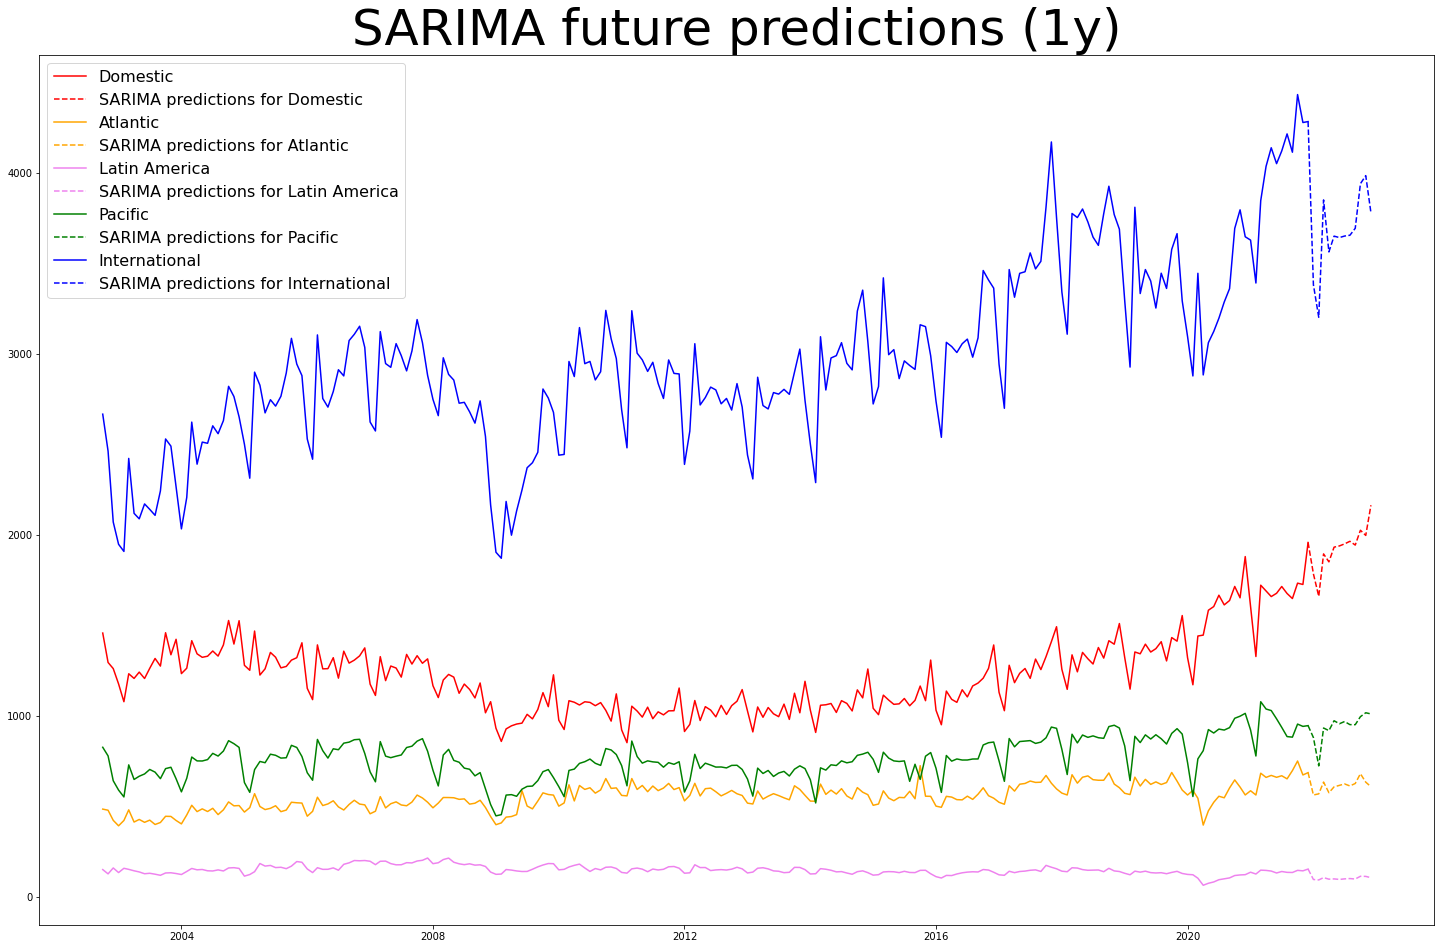

In [36]:
plot_series(df, predictions=df_sarima_future, pred_label='SARIMA predictions', title='SARIMA future predictions (1y)')

### 5.2 LSTM "mean" model

In [39]:
df_lstm_mean_future, _ = predict_lstm(model=models['mean'], train_s=test_s, index=pred_range, scaler=scaler, columns=df.columns,
                                   look_back=12, n_features=5, test_size=12)
df_lstm_mean_future = pd.concat([df_lstm_mean_future, df.tail(1)]).sort_index()
df_lstm_mean_future

,Domestic,Atlantic,Latin America,Pacific,International
2021-12-01,1958.740000,687.809000,155.231000,947.417000,4283.520000
2022-01-01,1538.220041,637.656993,132.636523,901.353267,3730.157658
2022-02-01,1517.639759,642.257133,130.437541,870.403438,3718.760079
2022-03-01,1696.906255,709.553301,137.332320,1037.444373,4295.952679
2022-04-01,1676.834200,675.370267,132.538510,1032.718885,4082.800415
2022-05-01,1716.056629,715.896137,143.443088,1085.383740,4314.532500
2022-06-01,1641.186078,702.064711,144.305311,1029.480687,4173.541833
2022-07-01,1592.804856,701.782842,143.301148,988.619597,4123.358364
2022-08-01,1604.057999,714.032879,143.802428,998.853429,4212.858478
2022-09-01,1648.072800,729.065755,145.458153,1042.656400,4347.522303


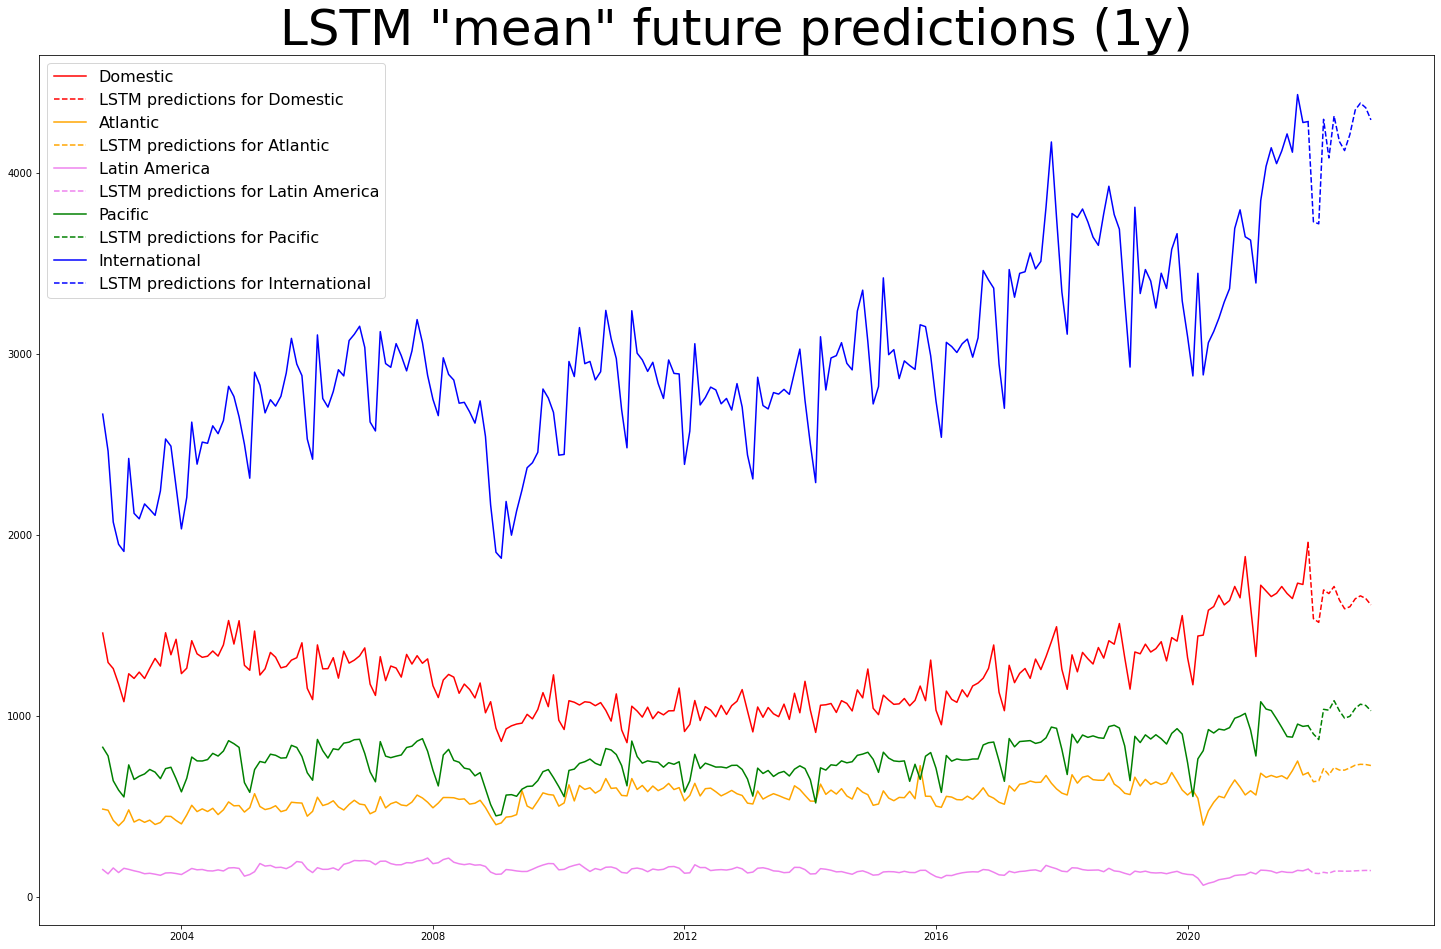

In [40]:
plot_series(df, predictions=df_lstm_mean_future, pred_label='LSTM predictions', title='LSTM "mean" future predictions (1y)')

### 5.3 LSTM "max" model

In [43]:
df_lstm_max_future, _ = predict_lstm(model=models['max'], train_s=test_s, index=pred_range, scaler=scaler, columns=df.columns,
                                   look_back=12, n_features=5, test_size=12)
df_lstm_max_future = pd.concat([df_lstm_max_future, df.tail(1)]).sort_index()
df_lstm_max_future

,Domestic,Atlantic,Latin America,Pacific,International
2021-12-01,1958.740000,687.809000,155.231000,947.417000,4283.520000
2022-01-01,1538.220041,637.656993,132.636523,901.353267,3730.157658
2022-02-01,1517.639759,642.257133,130.437541,870.403438,3718.760079
2022-03-01,1696.906255,709.553301,137.332320,1037.444373,4295.952679
2022-04-01,1676.834200,675.370267,132.538510,1032.718885,4082.800415
2022-05-01,1716.056629,715.896137,143.443088,1085.383740,4314.532500
2022-06-01,1641.186078,702.064711,144.305311,1029.480687,4173.541833
2022-07-01,1592.804856,701.782842,143.301148,988.619597,4123.358364
2022-08-01,1604.057999,714.032879,143.802428,998.853429,4212.858478
2022-09-01,1648.072800,729.065755,145.458153,1042.656400,4347.522303


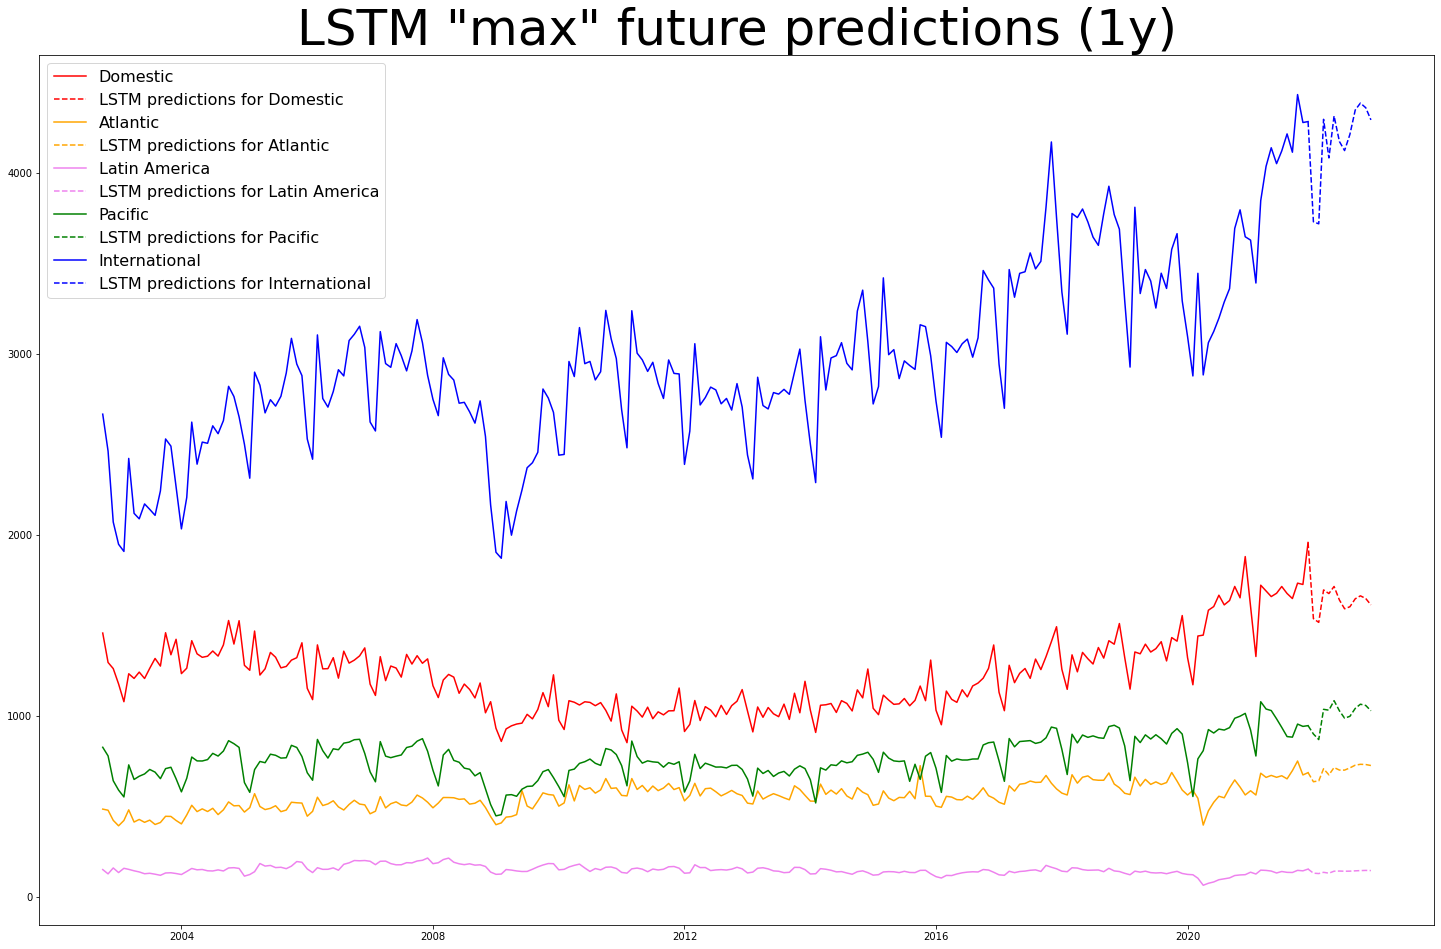

In [44]:
plot_series(df, predictions=df_lstm_max_future, pred_label='LSTM predictions', title='LSTM "max" future predictions (1y)')